In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.metrics import roc_auc_score, f1_score, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, plot_precision_recall_curve, classification_report, precision_score, recall_score, log_loss
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

В [задаче](https://www.kaggle.com/c/tabular-playground-series-may-2021/) рассматривается синтетический набор данных. Оригинальный набор рассчитан на предсказание категории продукта e-commerce по различным признакам. Хотя признаки анонимизированы, они имеют свойства, относящиеся к реальным.  
Предсказания оцениваются с помощью многоклассовой функции - Log Loss. Каждая строка в наборе данных 'train' помечена одним, истинным классом. Для каждой строки из набора 'test' вы должны предсказать вероятности принадлежности продукта к **каждому** классу. Формула выглядит следующим образом:  
$$\large\text{log loss} = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
# объединение test и train
data = train.append(test, ignore_index=True)

In [35]:
train.head(5)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   feature_0   100000 non-null  int64 
 2   feature_1   100000 non-null  int64 
 3   feature_2   100000 non-null  int64 
 4   feature_3   100000 non-null  int64 
 5   feature_4   100000 non-null  int64 
 6   feature_5   100000 non-null  int64 
 7   feature_6   100000 non-null  int64 
 8   feature_7   100000 non-null  int64 
 9   feature_8   100000 non-null  int64 
 10  feature_9   100000 non-null  int64 
 11  feature_10  100000 non-null  int64 
 12  feature_11  100000 non-null  int64 
 13  feature_12  100000 non-null  int64 
 14  feature_13  100000 non-null  int64 
 15  feature_14  100000 non-null  int64 
 16  feature_15  100000 non-null  int64 
 17  feature_16  100000 non-null  int64 
 18  feature_17  100000 non-null  int64 
 19  feature_18  100000 non-n

In [36]:
print(train.shape)
print(test.shape)

(100000, 52)
(50000, 51)


Видим 50 целочисленных признаков, пропусков нет

# Exploratory data analysis

## 1. Data visualization: First Overview

In [38]:
# seaborn style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16,6)

<Figure size 432x288 with 0 Axes>

### 1.1 Target Variable

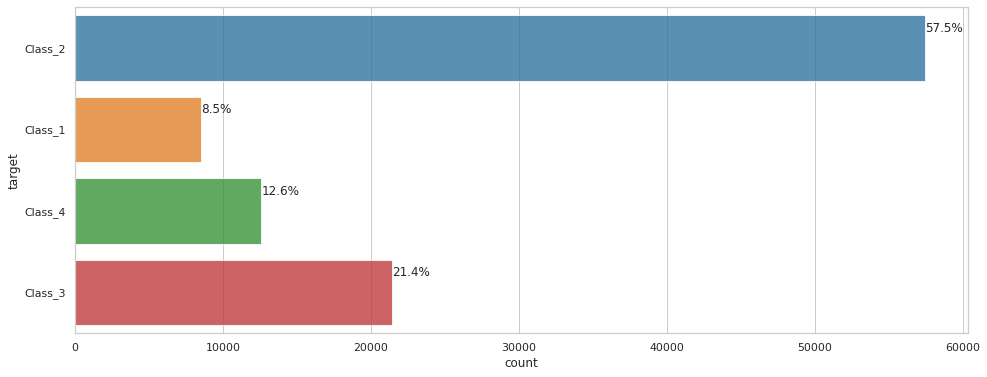

In [39]:
ax = sns.countplot(y='target', data=train, alpha=0.8)
total = train.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y))

Целевая переменная разделена на 4 класса. Класс №2 доминирующий. В целом, разница в распределении небольшая.

### 1.2 General feature analysis

In [14]:
train.drop(columns=['id']).describe().T\
        .style.bar(subset=['mean'])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
feature_0,100000.000000,0.257830,0.929033,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,100000.000000,0.431720,1.977862,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,100000.000000,0.114130,0.519584,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,100000.000000,0.590550,1.844558,0.000000,0.000000,0.000000,0.000000,26.000000
feature_4,100000.000000,0.599770,2.785531,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,100000.000000,0.160820,0.601149,0.000000,0.000000,0.000000,0.000000,10.000000
feature_6,100000.000000,0.731490,2.343465,0.000000,0.000000,0.000000,0.000000,27.000000
feature_7,100000.000000,1.228920,2.692732,0.000000,0.000000,0.000000,1.000000,31.000000
feature_8,100000.000000,0.903350,3.415258,0.000000,0.000000,0.000000,0.000000,39.000000
feature_9,100000.000000,0.940120,1.904172,0.000000,0.000000,0.000000,1.000000,17.000000


Среднее значение и стандартное отклонение варьируются в зависимости от переменной, так же наблюдается зависимость между этими статистиками. При увеличении среднего увеличивается стандартное отклонение.

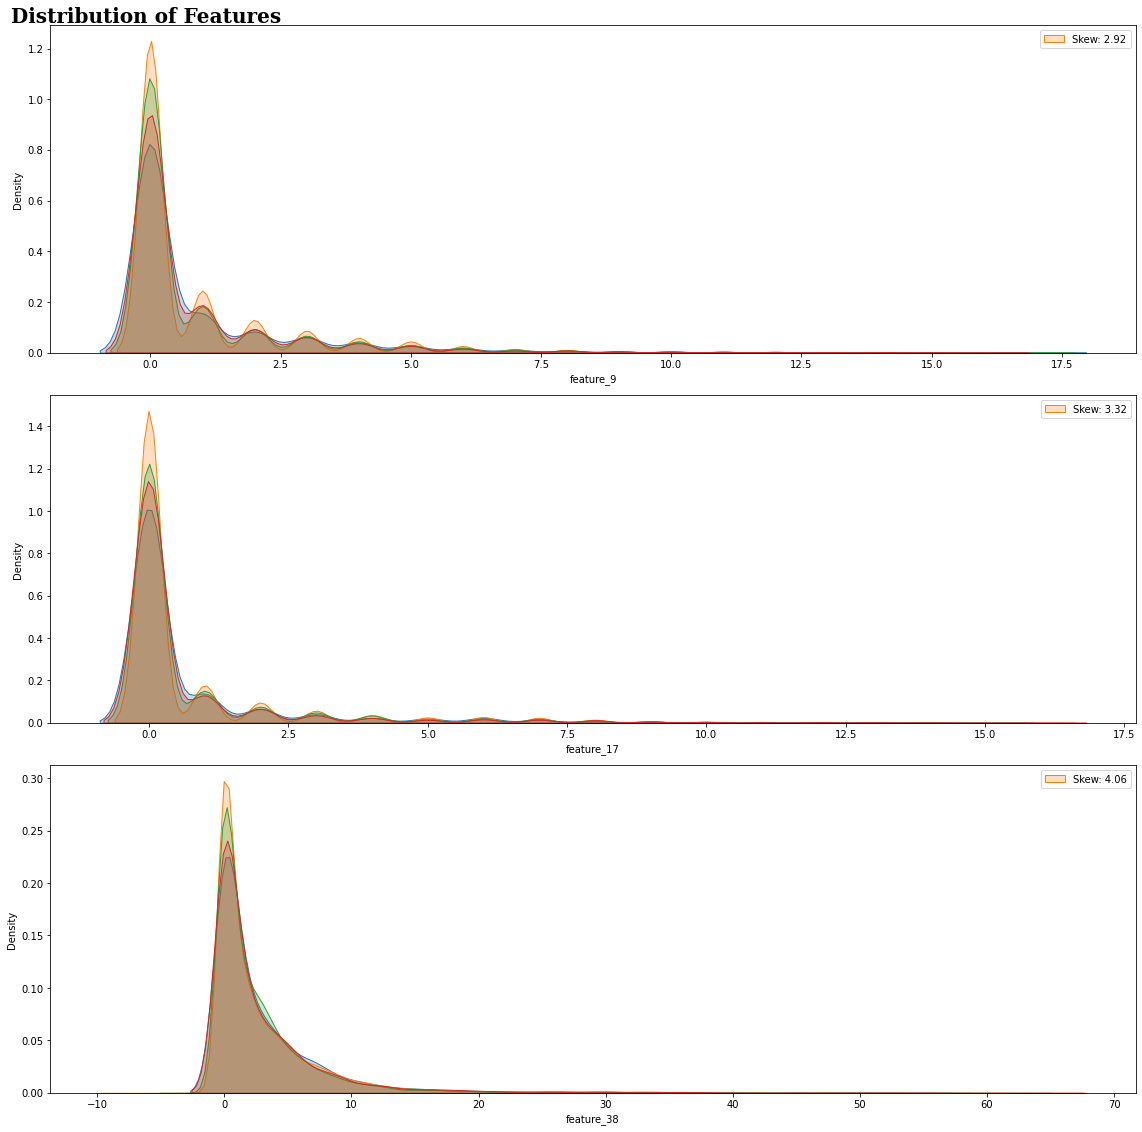

In [23]:
columns_to_plot = ['feature_9', 'feature_17', 'feature_38']

num_rows, num_cols = 3,1
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16))
f.suptitle('Distribution of Features', fontsize=20, fontweight='bold', fontfamily='serif', x=0.13)


for index, column in enumerate(train[columns_to_plot].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.kdeplot(train.loc[train['target'] == 'Class_1', column], shade=True, ax=axes[i])
    g = sns.kdeplot(train.loc[train['target'] == 'Class_2', column], label="Skew: %.2f"%(train[column].skew()), shade=True, ax=axes[i])
    g = g.legend(loc="best")
    sns.kdeplot(train.loc[train['target'] == 'Class_3', column], shade=True, ax=axes[i])
    sns.kdeplot(train.loc[train['target'] == 'Class_4', column], shade=True, ax=axes[i])

plt.tight_layout()
plt.show()

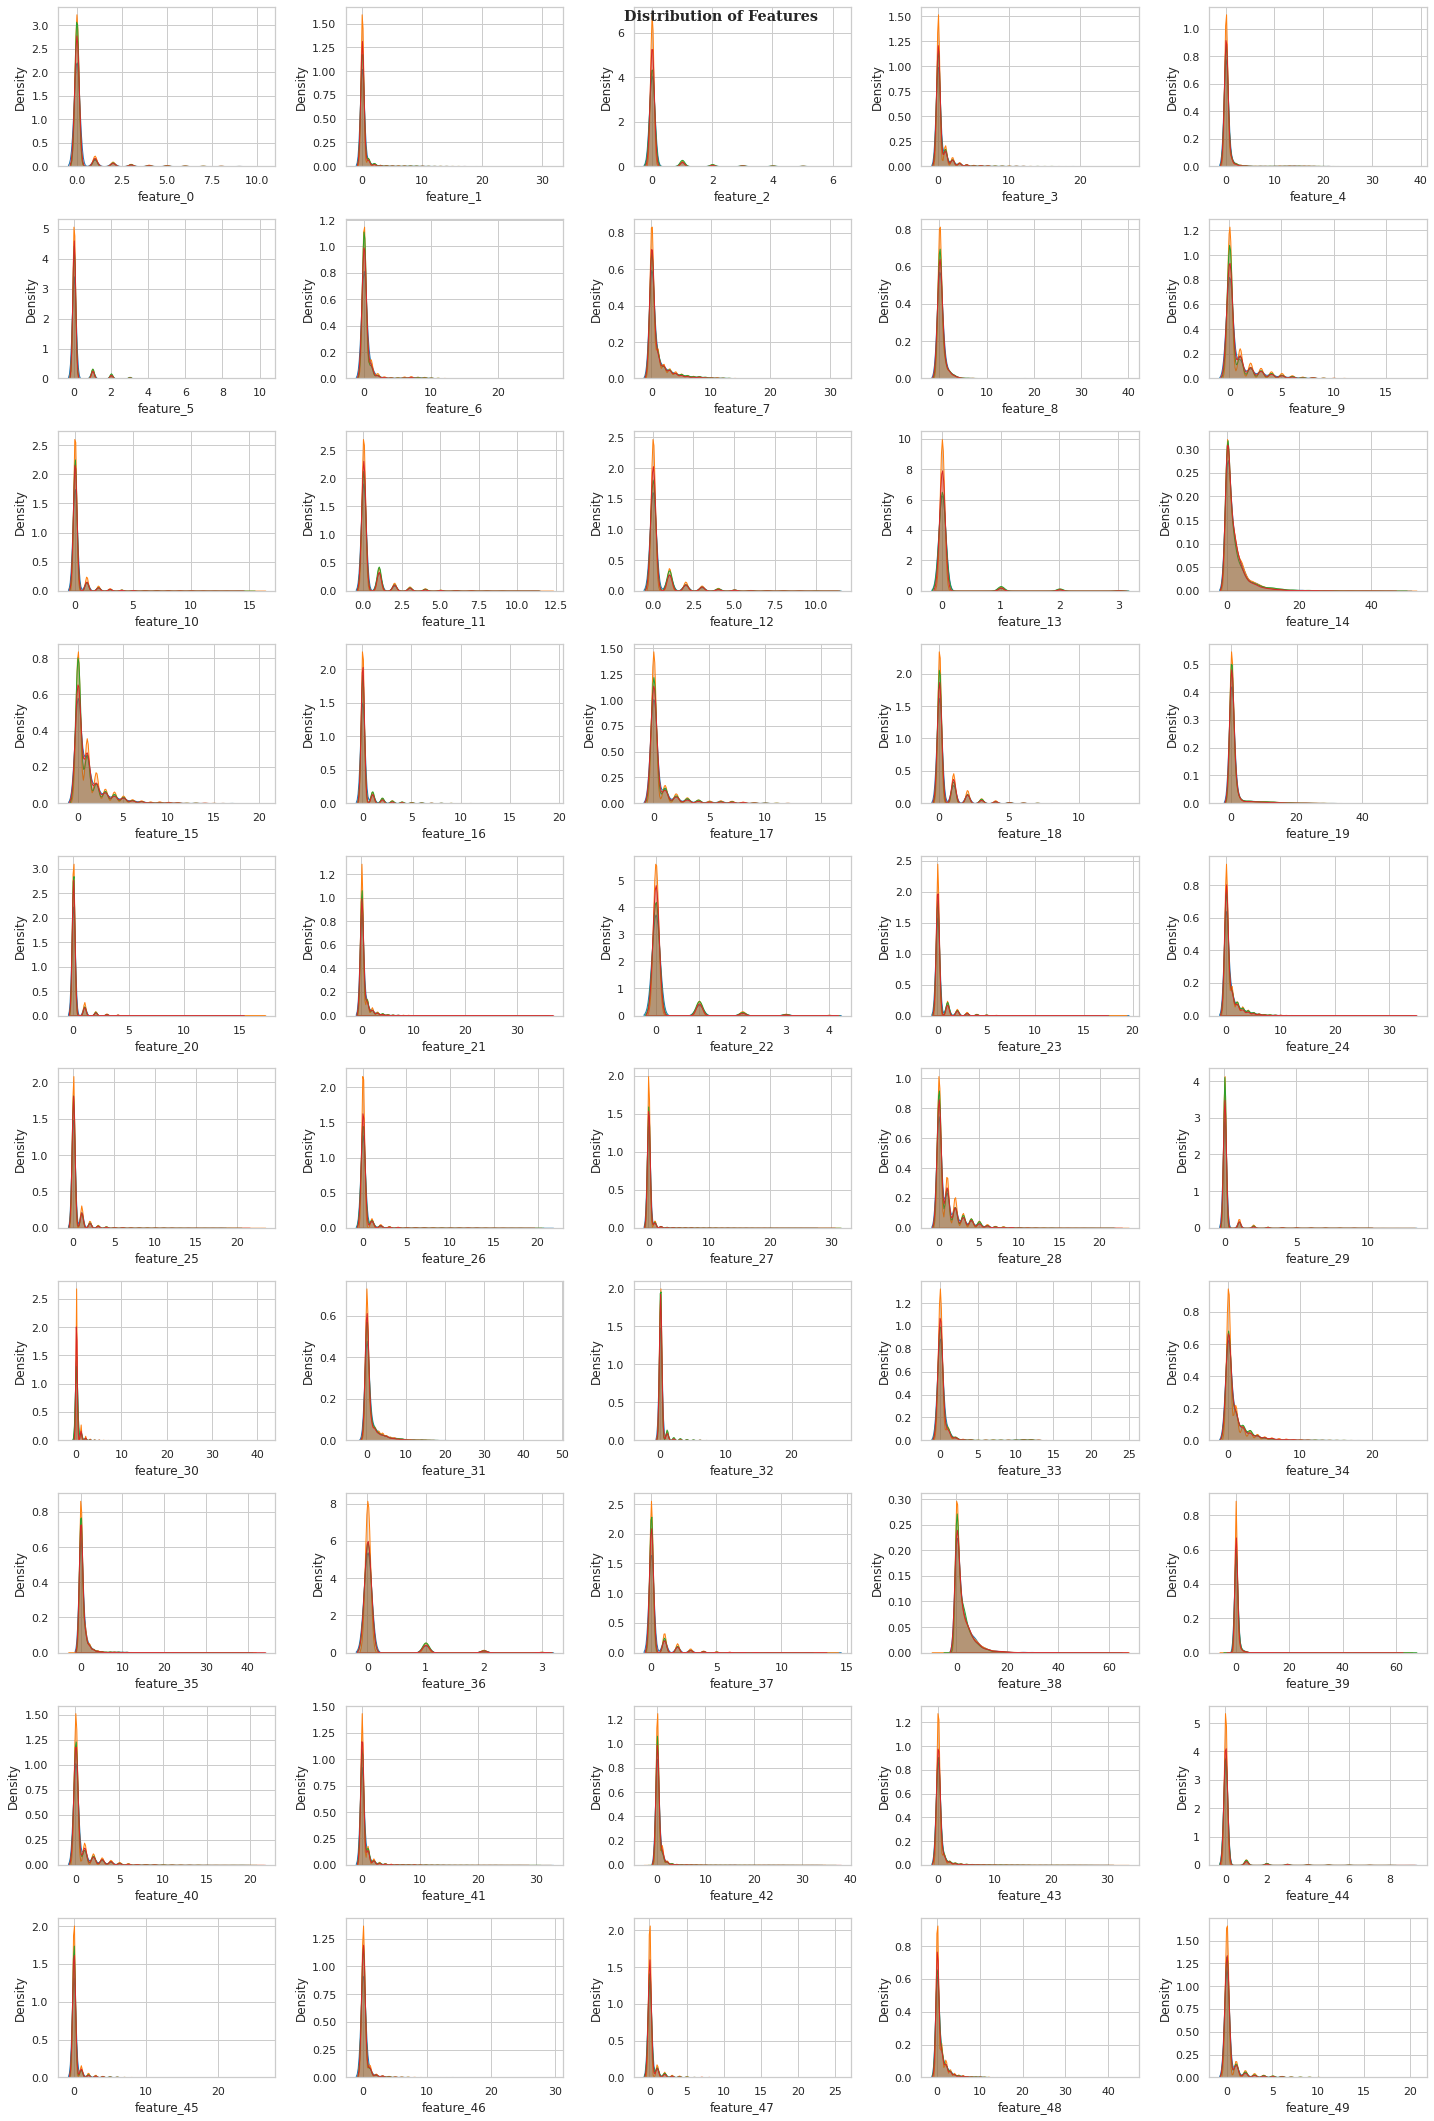

In [47]:
num_rows, num_cols = 10,5
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 30))
f.suptitle('Distribution of Features', fontweight='bold', fontfamily='serif')

for index, column in enumerate(train.drop(['id', 'target'], axis=1).columns):
    i,j = (index // num_cols, index % num_cols)

    sns.kdeplot(train.loc[train['target'] == 'Class_1', column], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train['target'] == 'Class_2', column], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train['target'] == 'Class_3', column], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train['target'] == 'Class_4', column], shade=True, ax=axes[i,j])

plt.tight_layout()
plt.show()

### 1.3 Correlation matrix

In [26]:
# импорт библиотеки для построения корреляционных матриц
# https://phik.readthedocs.io/en/latest/
import phik
from phik import resources, report

In [27]:
train_for_matrix = train.drop('id', axis=1)
thik = train_for_matrix.phik_matrix()

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49']


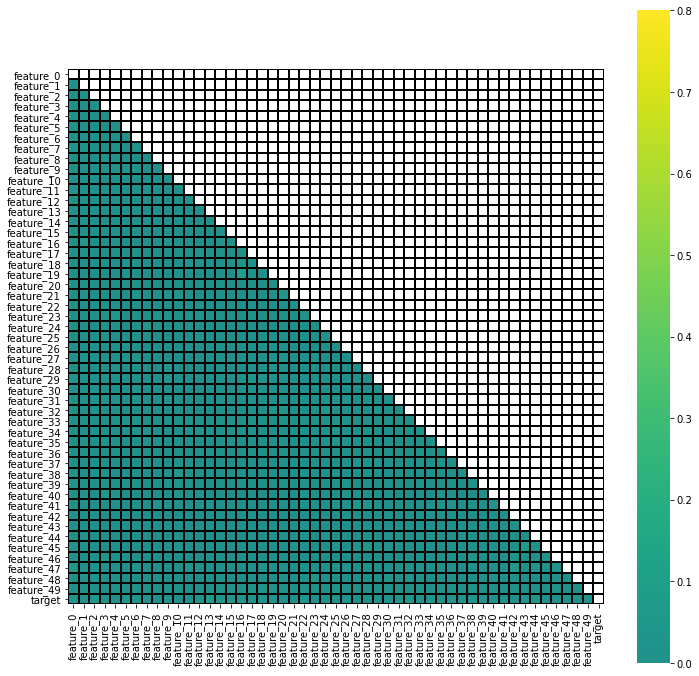

In [34]:
plt.figure(figsize=(12, 12))
mask = np.triu(np.ones_like(thik, dtype=np.bool))
sns.heatmap(thik, square=True, center=0, vmax=.8, cmap='viridis', linewidths=1, linecolor='black', cbar=True, mask=mask);